# 데이터 로드 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
from glob import glob 
import os 
from typing import Sequence, Tuple
import warnings
import datetime
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!tar -xvf '/content/drive/MyDrive/공유용/train_features.tar'

try:
  open_train_label = pd.read_csv('/content/drive/MyDrive/공유용/open_train_labels (1).csv.bz2')
except:
  open_train_label = pd.read_csv('/content/drive/MyDrive/데이터보관/공유용/open_train_labels (1).csv.bz2')

kden/
kden/kden_airport_config.csv.bz2
kden/kden_arrival_runway.csv.bz2
kden/kden_departure_runway.csv.bz2
kden/kden_etd.csv.bz2
kden/kden_first_position.csv.bz2
kden/kden_lamp.csv.bz2
kden/kden_mfs_runway_arrival_time.csv.bz2
kden/kden_mfs_runway_departure_time.csv.bz2
kden/kden_mfs_stand_arrival_time.csv.bz2
kden/kden_mfs_stand_departure_time.csv.bz2
kden/kden_tbfm_scheduled_runway_arrival_time.csv.bz2
kden/kden_tfm_estimated_runway_arrival_time.csv.bz2
kmia/
kmia/kmia_airport_config.csv.bz2
kmia/kmia_arrival_runway.csv.bz2
kmia/kmia_departure_runway.csv.bz2
kmia/kmia_etd.csv.bz2
kmia/kmia_first_position.csv.bz2
kmia/kmia_lamp.csv.bz2
kmia/kmia_mfs_runway_arrival_time.csv.bz2
kmia/kmia_mfs_runway_departure_time.csv.bz2
kmia/kmia_mfs_stand_arrival_time.csv.bz2
kmia/kmia_mfs_stand_departure_time.csv.bz2
kmia/kmia_tbfm_scheduled_runway_arrival_time.csv.bz2
kmia/kmia_tfm_estimated_runway_arrival_time.csv.bz2
kord/
kord/kord_airport_config.csv.bz2
kord/kord_arrival_runway.csv.bz2
kord/kor

In [4]:
folder_dir = glob('/content/*')
folder_dir = folder_dir[:-1]

In [5]:
 #공항별  디렉토리 모음 
dir = {}
for folder in folder_dir:
  csvs_dir = glob(folder+'/*.bz2')
  csvs_dir = pd.DataFrame(csvs_dir,columns=['dir'])
  dir[folder.split('/')[-1]] = csvs_dir
airport_names = list(dir.keys())
airport_names.remove('drive')

In [6]:
#원하는 파일의 디렉토리를 디렉토리 df에서 가져 옴 
def make_dir(dir,df):
  csv_dir = df[df['dir'].apply(lambda x : dir in x )].values[0][0]
  return csv_dir 

In [ ]:
# # Airport config 이외 다른 df 가져올 때 
# csvs_name = list(csvs_dir['dir'].apply(lambda x : x.split('katl/')[-1].split('.csv')[0].split('_',maxsplit=1)[-1]))
# for csv_name in tqdm(csvs_name):
#   exec(f"{csv_name} = pd.read_csv(make_dir('{csv_name}',csvs_dir))")

Config, Lamp 데이터 로드 

In [7]:
lamp_df = {} #공항 별 lamp 데이터 딕셔너리 
config_df = {} #공항 별 Configuration 데이터 딕셔너리 
for airport in airport_names:
  #lamp  파일 
  temp_lamp = make_dir('lamp',dir[airport])
  temp_lamp = pd.read_csv(temp_lamp) 
  lamp_df[airport] = temp_lamp.sort_values(by=['timestamp','forecast_timestamp']).reset_index().drop(columns='index')
  
  #Configuration 파일 
  temp_csv = pd.read_csv(make_dir('config',dir[airport]))
  config_df[airport] = temp_csv

# 데이터 전처리 

## Configuration 파일 
- Timestamp으로 30분 단위로 통일 시켜 줌 
- Configuration One hot encoding 변환 함 

In [8]:
#입력한 시간 대로 분할 
def split_config_min(split_df,split_min):
  split_df['timestamp'] = pd.to_datetime(split_df['timestamp'])
  split_df = split_df.sort_values(by='timestamp')
  split_df = pd.DataFrame(split_df.set_index('timestamp').airport_config.resample(split_min).ffill().dropna()).reset_index()
  return split_df
#One hot Encoding 
def one_hot(config,label):
  if config == label:
    return 1 
  else:
    return 0

In [9]:
#각 항공 별 label one hot encoding 
for airport in tqdm(airport_names):
  airport_config = split_config_min(config_df[airport],'30min') #Timestamp 30분 단위로 분할 

  labels = pd.get_dummies(open_train_label[open_train_label['airport']==airport],columns=['config']).columns[4:]
  labels = list(pd.Series(labels).apply(lambda x : x.split(':')[-1]))

  for label in labels:
    airport_config[label]='-'
    airport_config[label] = airport_config['airport_config'].apply(lambda x: one_hot(x,label))
  config_df[airport] = airport_config

100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


## Lamp 데이터

Wind direction -> 모델 학습을 통한 임베딩 사용 

In [10]:
def dtype_change(temp_lamp):
  temp_lamp['timestamp'] = pd.to_datetime(temp_lamp['timestamp'])
  temp_lamp['forecast_timestamp'] = pd.to_datetime(temp_lamp['forecast_timestamp'])
  return temp_lamp

In [11]:
lamp_columns = ['timestamp','forecast_timestamp','wind_direction','wind_speed']

for airport in airport_names:
  temp_lamp = lamp_df[airport][lamp_columns]
  temp_lamp = dtype_change(temp_lamp)
  lamp_df[airport] = temp_lamp

# 제너레이터 

## 사전설정

In [12]:
#기준 timestamps (input-output 연결 키 )
def make_timestamps(airport_config):
  airport_config = airport_config.sort_values(by='timestamp')
  timestamps = list(airport_config['timestamp'])[24:-12]
  return timestamps

### Lamp_df 
- 기준 시간 이전에 예측 된 데이터 중 가장 마지막 6개를 사용 
- Scaling은 아직 미적용 

In [13]:
def subset_lamp(temp_lamp,timestamp):
  upper_time = timestamp + np.timedelta64(6,'h')
  subset_lamp = temp_lamp[temp_lamp['timestamp']<=timestamp]
  subset_lamp = subset_lamp[subset_lamp['forecast_timestamp'] <=upper_time][-6:]
  subset_lamp = np.array(subset_lamp.drop(columns = ['timestamp','forecast_timestamp']))
  return subset_lamp

def batch_lamp(temp_lamp,batch_timestamp):
  batch_lamp_input = []
  for one_time in batch_timestamp:
    temp_subset_lamp = subset_lamp(temp_lamp,one_time)
    batch_lamp_input.append(temp_subset_lamp)
  return np.array(batch_lamp_input)

## Config_DF 용 

In [14]:
#기준 timestamp에서 과거 12시간 동안의 데이터를 호출 함 
def past_censor_data(airport_config_df: pd.DataFrame, std_timestamp: pd.Timestamp) -> Tuple[str, pd.DataFrame]:
    mask = airport_config_df["timestamp"] < std_timestamp
    subset = airport_config_df[mask][-24:] #6시간만 자르기 
    subset = np.array(subset.drop(columns = ['timestamp','airport_config']))
    return subset

#기준 timestamp에서 미래 6시간 동안의 데이터를 호출 함 
def future_censor_data(airport_config_df: pd.DataFrame, std_timestamp: pd.Timestamp):
    mask = airport_config_df["timestamp"] > std_timestamp
    subset = airport_config_df[mask][:12] #6시간만 자르기 
    subset = np.array(subset.drop(columns = ['timestamp','airport_config']))
    return subset

#batch size 대로 future or past 가져오는 것 
def batch_censor_data(airport_config,batch_timestamps,mode):
  shape = len(airport_config.columns[2:])
  return_config = []
  if mode =='past':    
    for n,batch_timestamp in enumerate(batch_timestamps):
      temp_config = past_censor_data(airport_config,batch_timestamp)
      return_config.append(temp_config)
    return np.array(return_config)
  if mode == 'future':
    for n,batch_timestamp in enumerate(batch_timestamps):
      temp_config = future_censor_data(airport_config,batch_timestamp)
      return_config.append(temp_config)
    return np.array(return_config).squeeze()

## 제너레이터 

In [47]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math

class DataGenerator(Sequence):
  def __init__(self,timestamps,
                 batch_size: int,
               shuffle : bool = False):
        self.airport_config = airport_config
        self.shuffle = shuffle
        self.lamp = lamp
        self.timestamps = timestamps
        self.batch_size = batch_size
        
  def __len__(self):
    return math.ceil(len(self.timestamps) / self.batch_size)

  def on_epoch_end(self):
    self.indices = np.arange(len(self.timestamps))
    if self.shuffle == True:
      np.random.shuffle(self.indices)
      self.timestamps = list(np.array(self.timestamps)[self.indices])
    
  def __getitem__(self, index):
    self.batch_timestamps = self.timestamps[index*self.batch_size:(index+1)*self.batch_size]
    #past data 
    past_configs = batch_censor_data(self.airport_config,self.batch_timestamps,'past')

    #future data 
    future_configs = batch_censor_data(self.airport_config,self.batch_timestamps,'future')

    #lamp data 
    # max_value = np.max(self.lamp.drop(columns=['timestamp','forecast_timestamp'])).values
    forecast_lamp = batch_lamp(self.lamp,self.batch_timestamps) # Scaling 

    return [np.array(past_configs),forecast_lamp], np.array(future_configs)
    # return np.array(past_configs), np.array(future_configs)

Generator shape 
- config input : 32,24,28
- lamp input : 32,6,2 
- config output : 32,12,28 

32 : batch_size 

#모델
**Regression 방식**
- 기준 시간 과거 12시간 동안의 Configuration을 이용해 이후 6시간 동안 미래 예측 
  - Input : 기준 시간 이전 12시간 동안 Configuration 
  - output : 기준 시간 이후 12시간 동안 Configuration

##사전설정

In [16]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Recall
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, LSTM, BatchNormalization,Input,Dropout,Dense,Conv2D,Concatenate,Flatten,Conv1D,Conv2D,MaxPooling1D
from tensorflow.keras.layers import Reshape,Embedding,concatenate
from tensorflow.keras.utils import plot_model
from keras.layers.pooling import GlobalAveragePooling2D,GlobalAveragePooling3D,AveragePooling3D

##콜백

In [17]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback
n=0
class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):
    global n

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])
    print(f' 현 회차 : {n}')

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    f'/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/best_model_{n}.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=30)         # 중지까지의 여유분

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 모니터링 대상
    patience=10,        # 대상ㅃ 기간동안 유지
    factor=0.2,         # 줄이는 양                              
    min_learning_rate=0.00001)     # 최소 학습율

callbacks = [ plot_losses,model_check_point]

In [18]:
def return_callbacks():
  model_check_point = ModelCheckpoint(
    f'/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/{airport}_best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)
  callbacks = [ plot_losses,model_check_point]
  return callbacks 

## 모델

- conf_input : (32, 24, shape) 
- lamp input : (32, 6, 2)
- conf output :  (32, 12, shape)

In [ ]:
def conv_layers(filter,input):
  x = Conv1D(filter,3,padding = 'same')(input)
  x = BatchNormalization()(x)
  out = Dropout(0.2)(x)
  return out

def conf_layer(conf_input):
  conf = Bidirectional(LSTM(128,return_sequences= True))(conf_input) #bidirec
  conf = Bidirectional(LSTM(64,return_sequences= True))(conf)
  conf = conv_layers(32,conf)
  conf_out = MaxPooling1D(2)(conf)
  return conf_out
def lamp_layer(lamp_input):
  lamp = Embedding(input_dim =37, output_dim = 4)(lamp_input)
  lamp = Dense(32,activation = 'relu')(lamp)
  lamp = Reshape((12,32))(lamp)
  return lamp

def concat_decoder(conf,lamp):
  concat = concatenate([conf,lamp])
  concat = Conv1D(32,2,padding='same')(concat)
  concat = BatchNormalization()(concat)
  concat = Dropout(0.2)(concat)
  concat = Dense(shape,activation = 'softmax')(concat)  
  return concat
def make_model(conf_input,lamp_input):
  conf = conf_layer(conf_input)
  lamp = lamp_layer(lamp_input)
  concat = concat_decoder(conf,lamp)
  model = Model([conf_input,lamp_input],concat)
  return model

## Compile

In [19]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [20]:
initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=lr_schedule,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)

## Training

In [21]:
for airport in airport_names:
  lamp_df[airport] = lamp_df[airport].dropna()

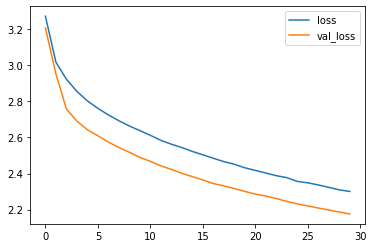

loss =  2.3005008697509766 , val_loss =  2.175938367843628
 현 회차 : 9

Epoch 30: val_loss improved from 2.18637 to 2.17594, saving model to /content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/kden_best_model.h5
246/246 [==============================] - 191s 777ms/step - loss: 2.3005 - mean_squared_logarithmic_error: 0.0088 - val_loss: 2.1759 - val_mean_squared_logarithmic_error: 0.0084


In [ ]:
#해당 airport 요소들 
models_list = {}
historys_list = {}
n=0
for airport in airport_names:
  if n>=3:
    airport_config = config_df[airport]
    lamp = lamp_df[airport]
    shape = len(airport_config.columns)-2
    timestamps = make_timestamps(airport_config)

    #train-valid  분할 
    from sklearn.model_selection import train_test_split
    train_timestamps,valid_timestamps = train_test_split(timestamps,test_size=0.1,random_state=42)

    #제너레이터
    BATCH_SIZE = 64
    train_generator = DataGenerator(train_timestamps,BATCH_SIZE,shuffle=True)
    valid_generator = DataGenerator(valid_timestamps,BATCH_SIZE)

    #모델
    conf_input = Input((24,shape))
    lamp_input = Input((6,2))
    model = make_model(conf_input,lamp_input)
    callbacks = return_callbacks()

    model.compile(optimizer=optimizer,loss = 'categorical_crossentropy',metrics=[tf.keras.metrics.MeanSquaredLogarithmicError()])
    history = model.fit(train_generator,validation_data = valid_generator, epochs=30,verbose=1,callbacks=callbacks)
    
    models_list[airport] = model
    historys_list[airport] = history
  n+=1

# model 로드 

In [29]:
model_lists = glob('/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/*.h5')
model_lists.sort()
model_lists

['/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/katl_best_model.h5',
 '/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/kclt_model.h5',
 '/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/kden_best_model.h5',
 '/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/kdfw_best_model.h5',
 '/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/kjfk_model.h5',
 '/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/kmem_best_model.h5',
 '/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/kmia_best_model.h5',
 '/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/kord_best_model.h5',
 '/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/kphx_best_model.h5',
 '/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/model/ksea_model.h5']

In [ ]:
models_list = {}
for i in range(10):
  model_dir = model_lists[i]
  model_name = model_dir.split('/')[-1].split('_')[0]
  models_list[model_name] = tf.keras.models.load_model(model_dir)

# Submission 

In [22]:
try:
  submission = pd.read_csv('/content/drive/MyDrive/공유용/open_submission_format (1).csv')
except:
  submission = pd.read_csv('/content/drive/MyDrive/데이터보관/공유용/open_submission_format (1).csv')
submission['timestamp'] = pd.to_datetime(submission['timestamp'])

## Regression 용 

In [54]:
def predict(airport,submission):
  model = models_list[airport]
  #submission 파일에서 해당 공항 timestamps만 추출 
  test_timestamps = list(np.unique(submission.loc[submission['airport']==airport,'timestamp']))
  #추출한 timestamps로 제너레이터 만듬
  test_generator = DataGenerator(test_timestamps,BATCH_SIZE)
  #위에서 만든 모델로 regression 
  y_ = model.predict(test_generator)
  return y_,submission,test_timestamps

#regression 결과를 0~1 사이의 값, sum ==1 로 만들어 줌 ---> rescaling 
def rescaling(y_):
  for j in tqdm(range(len(y_))):
    predicted = y_[j]
    total = np.sum(predicted,axis=1)
    for i in range(12):
      predicted[i] = predicted[i]/total[i]
    y_[j] = predicted
  return y_

def input_y_submission(y_,submission,test_timestamps):
  y_ = y_.reshape(810,-1)
  #위에서 rescaling된 값을 submission 파일에 넣어 줌 
  for time_num, time in tqdm(enumerate(test_timestamps)):
      submission.loc[(submission['airport']==airport) & (submission['timestamp']==time),'active'] = y_[time_num]
  return submission

In [ ]:
BATCH_SIZE=64
for airport in airport_names:
  airport_config = config_df[airport]
  lamp = lamp_df[airport]
  y_,submission,test_timestamps = predict(airport,submission)
  y_ = rescaling(y_)
  submission = input_y_submission(y_,submission,test_timestamps)

In [72]:
submission

airport      0
timestamp    0
lookahead    0
config       0
active       0
dtype: int64

In [ ]:
submission.loc[submission['active'].isnull(),'active'] = 0.037037

In [79]:
submission['active']

0          0.005162
1          0.006804
2          0.004133
3          0.004392
4          0.005393
             ...   
2468875    0.015721
2468876    0.011098
2468877    0.056715
2468878    0.683607
2468879    0.000927
Name: active, Length: 2468880, dtype: float64

In [74]:
submission.to_csv('submission.csv',index=False)

In [75]:
!cp /content/submission.csv '/content/drive/MyDrive/Colab Notebooks/Repositary/Airport_configuration/submission'